# model training and test

In [1]:
import numpy as np
import copy
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import transforms
from torchvision.transforms.functional import InterpolationMode
# from torchvision.models import resnet50, ResNet50_Weights
from torchvision.models import vgg16, VGG16_Weights

from torch.utils.data import DataLoader
from torch.utils.data import sampler
import torchvision.datasets as dset


# for plotting
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 20.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
# plt.rcParams['image.cmap'] = 'gray'
from matplotlib import cm

import collections
import PIL
import os
import datetime


if torch.cuda.is_available():
  device = torch.device('cuda')
else:
  device = torch.device('cpu')

torch.manual_seed(1)
if device == 'cuda:0':
    torch.cuda.manual_seed_all(1)

In [2]:
print(torch.__version__)
print(device)

1.12.1+cu113
cuda


In [3]:
ROOT_DIR = 'voc_data'

In [4]:
class VOCClassSegBase(torch.utils.data.Dataset):

    class_names = np.array([
        'background',
        'aeroplane',
        'bicycle',
        'bird',
        'boat',
        'bottle',
        'bus',
        'car',
        'cat',
        'chair',
        'cow',
        'diningtable',
        'dog',
        'horse',
        'motorbike',
        'person',
        'potted plant',
        'sheep',
        'sofa',
        'train',
        'tv/monitor',
    ])

    def __init__(self, root='voc_data/', split='train', transform_tf=True):
        self.root = root
        self.split = split
        self.transform_tf = transform_tf
     
        self.transform = transforms.Compose([
            transforms.Normalize(mean=(0, 0, 0), std=(255., 255., 255.)),
            transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
        ])

        dataset_dir = os.path.join(self.root, 'VOCdevkit/VOC2012')
        self.files = collections.defaultdict(list)
        for split in ['train', 'val']:
            imgsets_file = os.path.join(
                dataset_dir, 'ImageSets/Segmentation/%s.txt' % split)
            for did in open(imgsets_file):
                did = did.strip()
                img_file = os.path.join(dataset_dir, 'JPEGImages/%s.jpg' % did)
                lbl_file = os.path.join(
                    dataset_dir, 'SegmentationClass/%s.png' % did)
                self.files[split].append({
                    'img': img_file,
                    'lbl': lbl_file,
                })

    def __len__(self):
        return len(self.files[self.split])

    def __getitem__(self, index):
        # data file
        data_file = self.files[self.split][index]
        
        # load
        img_file = data_file['img']
        img = PIL.Image.open(img_file)
        img = torch.from_numpy(np.array(img)).to(torch.float)

        lbl_file = data_file['lbl']
        lbl = PIL.Image.open(lbl_file)
        lbl = torch.from_numpy(np.array(lbl)).to(torch.long)
        lbl = torch.unsqueeze(lbl, dim=0)

        # image preprocessing
        img = img.permute(2, 0, 1) # HWC -> CHW
        lbl[lbl == 255] = -1

        # image transform
        if self.transform_tf == True:
            return self.transform(img), lbl
        else:
            return img, lbl


train_data = VOCClassSegBase(root=ROOT_DIR, split='train', transform_tf=True)

train_data_loader = DataLoader(dataset=train_data, batch_size = 1, drop_last=True)

In [5]:
# Bilinear weights deconvolution Algorithm
def bilinear_kernel_init(Cin, Cout, kernel_size, device):
  factor = (kernel_size + 1) // 2
  if kernel_size % 2 == 1:
    center = factor - 1
  else:
    center = factor - 0.5

  og = (torch.arange(kernel_size).reshape(-1,1), torch.arange(kernel_size).reshape(1,-1))
  filter = (1 - torch.abs(og[0] - center) / factor) * (1 - torch.abs(og[1] - center) / factor)

  weight = torch.zeros((Cin, Cout, kernel_size, kernel_size))
  weight[range(Cin), range(Cout), :, :] = filter
  return weight.clone().to(device)

In [6]:
class FCN18(nn.Module):
  def __init__(self, class_n, device=device): # class 20 + 1(bakcground)
    super().__init__()
    self.downsample1 = nn.Sequential(
      nn.Conv2d(3,64,3,padding=100),
      nn.BatchNorm2d(64),
      nn.ReLU(inplace=True),
      nn.Conv2d(64,64,3,padding=1),
      nn.BatchNorm2d(64),
      nn.ReLU(inplace=True),
      nn.MaxPool2d(2, stride=2, ceil_mode=True)
    ).to(device)
    self.downsample2 = nn.Sequential(
      nn.Conv2d(64,128,3,padding=1),
      nn.BatchNorm2d(128),
      nn.ReLU(inplace=True),
      nn.Conv2d(128,128,3,padding=1),
      nn.BatchNorm2d(128),
      nn.ReLU(inplace=True),
      nn.MaxPool2d(2, stride=2, ceil_mode=True)
    ).to(device)
    self.downsample3 = nn.Sequential(
      nn.Conv2d(128,256,3,padding=1),
      nn.BatchNorm2d(256),
      nn.ReLU(inplace=True),
      nn.Conv2d(256,256,3,padding=1),
      nn.BatchNorm2d(256),
      nn.ReLU(inplace=True),
      nn.Conv2d(256,256,3,padding=1),
      nn.BatchNorm2d(256),
      nn.ReLU(inplace=True),
      nn.MaxPool2d(2, stride=2, ceil_mode=True)
    ).to(device)
    self.downsample4 = nn.Sequential(
      nn.Conv2d(256,512,3,padding=1),
      nn.BatchNorm2d(512),
      nn.ReLU(inplace=True),
      nn.Conv2d(512,512,3,padding=1),
      nn.BatchNorm2d(512),
      nn.ReLU(inplace=True),
      nn.Conv2d(512,512,3,padding=1),
      nn.BatchNorm2d(512),
      nn.ReLU(inplace=True),
      nn.MaxPool2d(2, stride=2, ceil_mode=True)
    ).to(device)
    self.downsample5 = nn.Sequential(
      nn.Conv2d(512,512,3,padding=1),
      nn.BatchNorm2d(512),
      nn.ReLU(inplace=True),
      nn.Conv2d(512,512,3,padding=1),
      nn.BatchNorm2d(512),
      nn.ReLU(inplace=True),
      nn.Conv2d(512,512,3,padding=1),
      nn.BatchNorm2d(512),
      nn.ReLU(inplace=True),
      nn.MaxPool2d(2, stride=2, ceil_mode=True)
    ).to(device)

    # fc layers
    self.fc6 = nn.Sequential(
      nn.Conv2d(512, 4096, kernel_size=7, bias=False), 
      nn.ReLU(),
      nn.Dropout2d()
    ).to(device)
    nn.init.xavier_normal_(self.fc6[0].weight)
    self.fc7 = nn.Sequential(
      nn.Conv2d(4096, 4096, kernel_size=1, bias=False), 
      nn.ReLU(),
      nn.Dropout2d()
    ).to(device)
    nn.init.xavier_normal_(self.fc7[0].weight)

    # fc before upsample : to class_n
    self.score_pool3 = nn.Conv2d(256, class_n, kernel_size=1).to(device)
    nn.init.xavier_normal_(self.score_pool3.weight)

    self.score_pool4 = nn.Conv2d(512, class_n, kernel_size=1).to(device)
    nn.init.xavier_normal_(self.score_pool4.weight)

    self.score_final = nn.Conv2d(4096, class_n, kernel_size=1).to(device)
    nn.init.xavier_normal_(self.score_final.weight)
    
    # stride s, padding s/2, kernelsize 2s -> 2 times upsampling for images
    self.upsample_make_16s = nn.ConvTranspose2d(class_n, class_n, kernel_size=4, stride=2, bias=False).to(device) # to 1/16 padding=1,
    self.upsample_make_16s.weight.data.copy_(bilinear_kernel_init(class_n, class_n, 4, device))

    self.upsample_make_8s = nn.ConvTranspose2d(class_n, class_n, kernel_size=4,  stride=2, bias=False).to(device) # to 1/8 padding=1,
    self.upsample_make_8s.weight.data.copy_(bilinear_kernel_init(class_n, class_n, 4, device))
    
    self.upsample_to_score = nn.ConvTranspose2d(class_n, class_n, kernel_size=16,  stride=8, bias=False).to(device) # to 1 padding=4,
    self.upsample_to_score.weight.data.copy_(bilinear_kernel_init(class_n, class_n, 16, device))
    for param in self.upsample_to_score.parameters(): # freeze the last layer
      param.requires_grad = False

  def crop_(self, crop_obj, base_obj, crop=True):
      if crop:
          c = (crop_obj.size()[2] - base_obj.size()[2]) // 2
          crop_obj = crop_obj[:,:,c:c+base_obj.shape[2],c:c+base_obj.shape[3]]
          # crop_obj = F.pad(crop_obj, (-c, -c, -c, -c))
          # crop_obj = torchvision.transforms.CenterCrop((base_obj.shape[2], base_obj.shape[3]))
      return crop_obj

  def forward(self, x):
    input_x = x.clone()
    # print("input shape : ", x.shape)
    
    x = self.downsample1(x) # 1/2
    x = self.downsample2(x) # 1/4
    x = self.downsample3(x) # 1/8
    pool3 = x
    x = self.downsample4(x) # 1/16
    pool4 = x
    x = self.downsample5(x) # 1/32

    x = self.fc6(x) # 1/32
    x = self.fc7(x) # 1/32

    x = self.score_final(x)
    x = self.upsample_make_16s(x)
    score_fc_16s = x # 1/16

    x = self.score_pool4(pool4) # 1/16 
    x = self.crop_(x, score_fc_16s)
    score_pool4c = x # 1/16

    x = score_fc_16s + score_pool4c # 1/16
    x = self.upsample_make_8s(x)
    score_fc_8s = x # 1/8

    x = self.score_pool3(pool3)
    x = self.crop_(x, score_fc_8s)
    score_pool3c = x # 1/8

    x = score_fc_8s + score_pool3c # 1/8
    x = self.upsample_to_score(x)
    x = self.crop_(x, input_x)

    out = x
    # print("out shape : ", out.shape)
    return out

In [7]:
epochs = 200
lr = 1e-4
weight_decay = 2e-4
momentum = 0.9 

model = FCN18(21).to(device)
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)
criterion = nn.CrossEntropyLoss(ignore_index=-1).to(device)

# scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[50], gamma=0.5)

# ############################################################ fix this path
# PATH = 'fcn_model/21class_trained/model_8_14_14_14_25_21class' # need to be fixed everytime

# checkpoint = torch.load(PATH)
# model.load_state_dict(checkpoint['model_state_dict']) 
# optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
# epoch = checkpoint['epoch']
# loss = checkpoint['loss']

# model.train()
# print('train mode start')

In [8]:
# # train code
# def train(model, epochs, optimizer, criterion, verbos_iter=False, verbos_epoch=True):
#   loss_history =[]
#   last_LOSS = 10 ** 9

#   for epoch in range(epochs):
#     running_loss = 0
#     for iter, (train_img, train_gt_img) in enumerate(train_data_loader):
#       train_img = train_img.to(device)
#       train_gt_img = train_gt_img.squeeze(dim=1).to(device)

#       # prediction
#       score_img = model(train_img)
#       score_img = score_img.reshape(-1, score_img.shape[1]) # C H W
#       train_gt_img = train_gt_img.reshape(-1, )

#       loss = criterion(score_img, train_gt_img)

#       optimizer.zero_grad()
#       loss.backward()
#       optimizer.step()
      
#       if verbos_iter == True:
#         print("epoch %d, iteration: %d, loss : %f "%(epoch + 1, iter + 1, loss))

#       running_loss += loss
    
#     if verbos_epoch == True:
#       print('======================================')
#       print("epoch %d, loss : %f "%(epoch + 1, running_loss / len(train_data_loader)))

#     now = datetime.datetime.now()
#     EPOCH = epoch
#     PATH = "fcn_model/model_%d%d_%d" % (now.month, now.day, epoch)
#     LOSS = running_loss
#     loss_history.append(LOSS.item())
    
#     if last_LOSS > LOSS:
#       torch.save({
#                   'epoch': EPOCH,
#                   'model_state_dict': model.state_dict(),
#                   'optimizer_state_dict': optimizer.state_dict(),
#                   'loss': LOSS,
#                   }, PATH)
#       last_LOSS = LOSS
      
#     # scheduler.step()
  
#   print("Training End")
#   return loss_history

# history = train(model, epochs, optimizer, criterion)

# plt.plot(history)
# plt.show()

## Test

In [9]:
# test_model = model
# test_model.eval()
# print('model evaluation start')

test_model = FCN18(21).to(device)
############################################################ fix this path
PATH = 'fcn_model/model_94_50'

checkpoint = torch.load(PATH)
test_model.load_state_dict(checkpoint['model_state_dict'])

test_model.eval()
print('model evaluation start')

model evaluation start


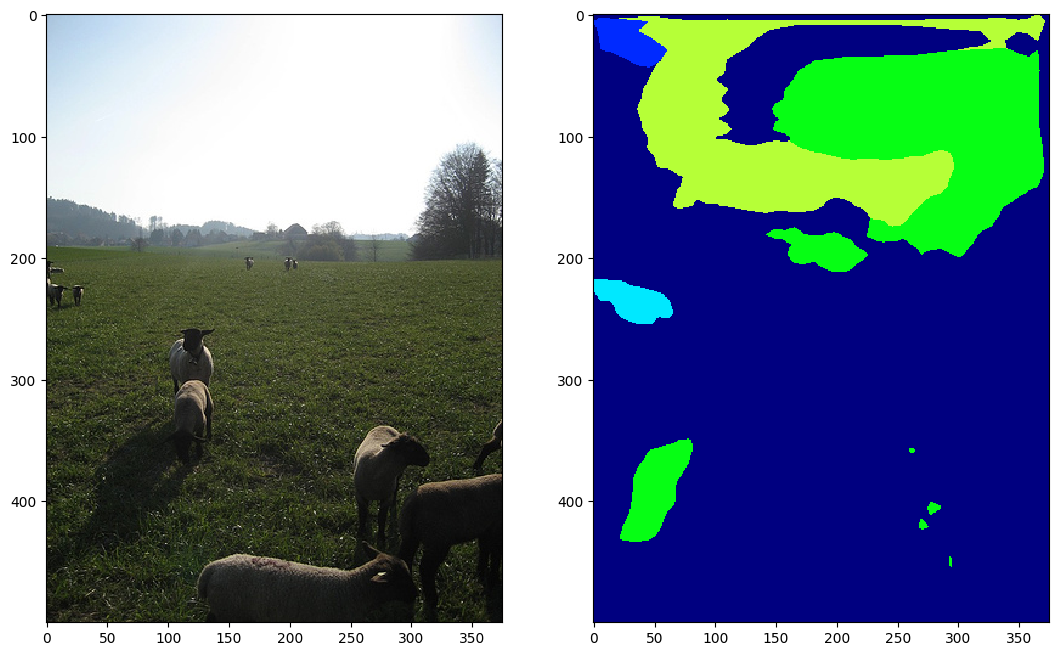

In [10]:
# segmentation : plot image
with open(os.path.join(ROOT_DIR, "VOCdevkit/VOC2012/ImageSets/Segmentation/train.txt"), 'r') as f:
  lines = f.readlines()
for i in range(len(lines)):
  lines[i] =  lines[i].strip('\n')

idx = 1000
test_jpg_path = lines[idx] + '.jpg'
test_image = PIL.Image.open(os.path.join(ROOT_DIR, 'VOCdevkit/VOC2012', "JPEGImages", test_jpg_path))

# test image showing
plt.figure(figsize=(20, 40))
plt.subplot(1,3,1)
plt.imshow(test_image)

# test image transform & input to test model
test_image = np.array(test_image)
test_image = torch.from_numpy(test_image).to(torch.float).permute(2,0,1).to(device)
ori_x, ori_y = test_image.shape[1], test_image.shape[2]

test_image = torch.unsqueeze(test_image, dim=0)

test_transform = transforms.Compose([
    # transforms.Resize((320,320), interpolation=InterpolationMode.BILINEAR),
    transforms.Normalize(mean=(0, 0, 0), std=(255., 255., 255.)),
    transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
])
# return_transform = transforms.Compose([
#     transforms.Resize((ori_x, ori_y), interpolation=InterpolationMode.BILINEAR),
# ])

test_seg = test_model(test_transform(test_image))
# test_seg = return_transform(test_seg)
# test_seg[test_seg <= 8] = 0 # Thresholding

# model prediction
test_image_channel_idx = torch.argmax(torch.squeeze(test_seg, dim=0), dim=0).cpu()

# model prediction to PIL
test_image_PIL = PIL.Image.fromarray(
    np.uint8(cm.gist_ncar(test_image_channel_idx.detach().numpy()*10)*255)
    )

# predicted data showing
plt.subplot(1,3,2)
plt.imshow(test_image_PIL)
plt.show()

# # model prediction for only one class
# test_image_channel_idx_copy = copy.deepcopy(test_image_channel_idx)
# finding_class = 2 # editable
# test_image_channel_idx_copy[test_image_channel_idx_copy != finding_class] = 0

# # to PIL
# test_image_PIL = PIL.Image.fromarray(
#     np.uint8(cm.gist_ncar(test_image_channel_idx_copy.detach().numpy()*10)*255)
#     )

# # predicted data showing
# plt.subplot(1,3,3)
# plt.imshow(test_image_PIL)
# plt.show()

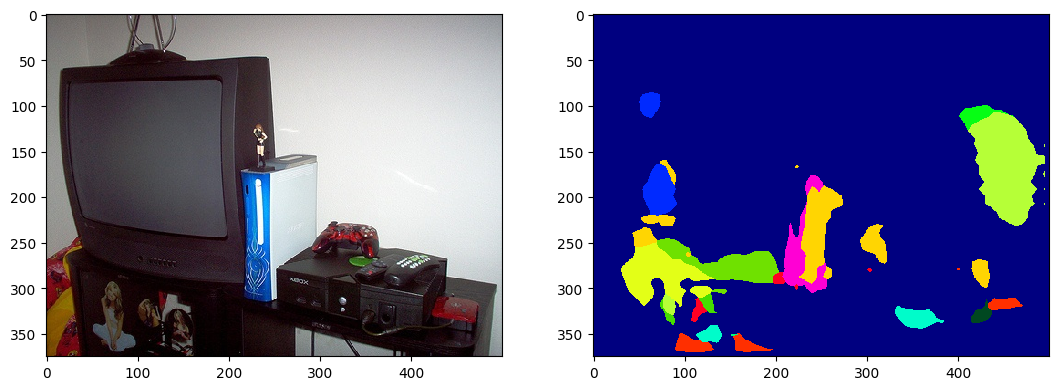

In [11]:
# segmentation : plot image
with open(os.path.join(ROOT_DIR, "VOCdevkit/VOC2012/ImageSets/Segmentation/val.txt"), 'r') as f:
  lines = f.readlines()
for i in range(len(lines)):
  lines[i] =  lines[i].strip('\n')

idx = 300
test_jpg_path = lines[idx] + '.jpg'
test_image = PIL.Image.open(os.path.join(ROOT_DIR, 'VOCdevkit/VOC2012', "JPEGImages", test_jpg_path))

# test image showing
plt.figure(figsize=(20, 40))
plt.subplot(1,3,1)
plt.imshow(test_image)

# test image transform & input to test model
test_image = np.array(test_image)
test_image = torch.from_numpy(test_image).to(torch.float).permute(2,0,1).to(device)
ori_x, ori_y = test_image.shape[1], test_image.shape[2]

test_image = torch.unsqueeze(test_image, dim=0)

test_transform = transforms.Compose([
    # transforms.Resize((320,320), interpolation=InterpolationMode.BILINEAR),
    transforms.Normalize(mean=(0, 0, 0), std=(255., 255., 255.)),
    transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
])
# return_transform = transforms.Compose([
#     transforms.Resize((ori_x, ori_y), interpolation=InterpolationMode.BILINEAR),
# ])

test_seg = test_model(test_transform(test_image))
# test_seg = return_transform(test_seg)
# test_seg[test_seg <= 8] = 0 # Thresholding

# model prediction
test_image_channel_idx = torch.argmax(torch.squeeze(test_seg, dim=0), dim=0).cpu()

# model prediction to PIL
test_image_PIL = PIL.Image.fromarray(
    np.uint8(cm.gist_ncar(test_image_channel_idx.detach().numpy()*10)*255)
    )

# predicted data showing
plt.subplot(1,3,2)
plt.imshow(test_image_PIL)
plt.show()

# # model prediction for only one class
# test_image_channel_idx_copy = copy.deepcopy(test_image_channel_idx)
# finding_class = 2 # editable
# test_image_channel_idx_copy[test_image_channel_idx_copy != finding_class] = 0

# # to PIL
# test_image_PIL = PIL.Image.fromarray(
#     np.uint8(cm.gist_ncar(test_image_channel_idx_copy.detach().numpy()*10)*255)
#     )

# # predicted data showing
# plt.subplot(1,3,3)
# plt.imshow(test_image_PIL)
# plt.show()

In [12]:
'''
referenced from
https://stackoverflow.com/a/48383182
'''

# IoU function
def iou(pred, target, n_classes = 4):
  ious = []
  pred = pred.view(-1)
  target = target.view(-1)

  # Ignore IoU for background class ("0")
  for cls in range(1, n_classes):  # This goes from 1:n_classes-1 -> class "0" is ignored
    pred_inds = pred == cls
    target_inds = target == cls
    
    intersection = int((pred_inds * target_inds).sum().item())
    union = int((pred_inds + target_inds).sum().item())
    
    # print(intersection, union) # for test
    
    if int(target_inds.sum().item()) == 0 and int(pred_inds.sum().item()) == 0:
      continue
    
    if union == 0:
      ious.append(float('nan'))  # If there is no ground truth, do not include in evaluation
    else:
      ious.append(float(intersection) / float(union)) # float(max(union, 1)))
    
  return np.array(ious), np.array(ious).mean()

In [13]:
# for test data
with open(os.path.join(ROOT_DIR, "VOCdevkit/VOC2012/ImageSets/Segmentation/val.txt"), 'r') as f:
  lines = f.readlines()
for i in range(len(lines)):
  lines[i] =  lines[i].strip('\n')

iter = 0
iou_stack = 0

for idx in range(len(lines)):
  test_jpg_path = lines[idx] + '.jpg'
  test_png_path = lines[idx] + '.png'
  test_image = PIL.Image.open(os.path.join(ROOT_DIR, 'VOCdevkit/VOC2012', "JPEGImages", test_jpg_path))
  test_gt_image = PIL.Image.open(os.path.join(ROOT_DIR, 'VOCdevkit/VOC2012', "SegmentationObject", test_png_path))

  # test image transform & input to test model
  test_image = np.array(test_image)
  test_image = torch.from_numpy(test_image).to(torch.float).permute(2,0,1).to(device)
  ori_x, ori_y = test_image.shape[1], test_image.shape[2]
  test_image = torch.unsqueeze(test_image, dim=0)

  test_transform = transforms.Compose([
      transforms.Normalize(mean=(0, 0, 0), std=(255., 255., 255.)),
      transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
  ])
  # return_transform = transforms.Compose([
  #     transforms.Resize((ori_x, ori_y), interpolation=InterpolationMode.BILINEAR),
  # ])

  test_seg = test_model(test_transform(test_image))
  # test_seg = return_transform(test_seg)
  # test_seg[test_seg <= 8] = 0 # Thresholdings
  test_seg = torch.squeeze(test_seg, dim=0)

  # model prediction
  test_image_channel_idx = torch.argmax(test_seg, dim=0).cpu()

  # ground truth image getting
  test_gt_image = np.array(test_gt_image)
  test_gt_image = torch.from_numpy(test_gt_image).to(torch.int)

  iter += 1
  _, metric = iou(test_image_channel_idx, test_gt_image, 21)
  print("iou of %d th " % (iter), " : ", metric)
  iou_stack += metric

mean_iou = iou_stack / iter
print("mean_iou : ", mean_iou)

iou of 1 th   :  0.0
iou of 2 th   :  0.0
iou of 3 th   :  0.0
iou of 4 th   :  0.0
iou of 5 th   :  0.0
iou of 6 th   :  0.0
iou of 7 th   :  0.0
iou of 8 th   :  0.0
iou of 9 th   :  0.0
iou of 10 th   :  0.0
iou of 11 th   :  0.0
iou of 12 th   :  0.0
iou of 13 th   :  0.0
iou of 14 th   :  0.0
iou of 15 th   :  0.0
iou of 16 th   :  0.0
iou of 17 th   :  0.0
iou of 18 th   :  0.0
iou of 19 th   :  0.0
iou of 20 th   :  0.0
iou of 21 th   :  0.0
iou of 22 th   :  0.0
iou of 23 th   :  0.0
iou of 24 th   :  0.0
iou of 25 th   :  0.0
iou of 26 th   :  0.0
iou of 27 th   :  0.0
iou of 28 th   :  0.0
iou of 29 th   :  0.0
iou of 30 th   :  0.0
iou of 31 th   :  0.0
iou of 32 th   :  0.0
iou of 33 th   :  0.0
iou of 34 th   :  0.0
iou of 35 th   :  0.0
iou of 36 th   :  0.0
iou of 37 th   :  0.0
iou of 38 th   :  0.0
iou of 39 th   :  0.0
iou of 40 th   :  0.0010334137099552187
iou of 41 th   :  0.0
iou of 42 th   :  0.0
iou of 43 th   :  0.0
iou of 44 th   :  0.0
iou of 45 th   :  0.0
i

RuntimeError: CUDA out of memory. Tried to allocate 60.00 MiB (GPU 0; 5.79 GiB total capacity; 3.71 GiB already allocated; 65.50 MiB free; 4.29 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [ ]:
def foreground_pixel_acc(pred, gt, class_num):
  true_positive_stack = 0
  all_stack = 0
  for class_i in range(1, class_num+1):
    true_positive = (pred == class_i) * (gt == class_i)
    all = (gt == class_i)

    true_positive_stack += true_positive.sum()
    all_stack += all.sum()

  return true_positive_stack / all_stack

In [ ]:
# foreground pixel accuracy

with open(os.path.join(ROOT_DIR, "VOCdevkit/VOC2012/ImageSets/Segmentation/val.txt"), 'r') as f:
  lines = f.readlines()
for i in range(len(lines)):
  lines[i] =  lines[i].strip('\n')

iter = 0
acc_stack = 0

for idx in range(len(lines)):
  test_jpg_path = lines[idx] + '.jpg'
  test_png_path = lines[idx] + '.png'
  test_image = PIL.Image.open(os.path.join(ROOT_DIR, 'VOCdevkit/VOC2012', "JPEGImages", test_jpg_path))
  test_gt_image = PIL.Image.open(os.path.join(ROOT_DIR, 'VOCdevkit/VOC2012', "SegmentationObject", test_png_path))

  # test image transform & input to test model
  test_image = np.array(test_image)
  test_image = torch.from_numpy(test_image).to(torch.float).permute(2,0,1).to(device)
  ori_x, ori_y = test_image.shape[1], test_image.shape[2]
  test_image = torch.unsqueeze(test_image, dim=0)

  test_transform = transforms.Compose([
      transforms.Resize((320,320), interpolation=InterpolationMode.NEAREST),
      transforms.Normalize(mean=(0, 0, 0), std=(255., 255., 255.)),
      transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
  ])
  return_transform = transforms.Compose([
      transforms.Resize((ori_x, ori_y), interpolation=InterpolationMode.NEAREST),
  ])

  test_seg = test_model(test_transform(test_image))
  test_seg = return_transform(test_seg)
  # test_seg[test_seg <= 8] = 0 # Thresholdings
  test_seg = torch.squeeze(test_seg, dim=0)

  # model prediction
  test_image_channel_idx = torch.argmax(test_seg, dim=0).cpu()

  # ground truth image getting
  test_gt_image = np.array(test_gt_image)
  test_gt_image = torch.from_numpy(test_gt_image).to(torch.int)

  iter += 1
  metric = foreground_pixel_acc(test_image_channel_idx, test_gt_image, 21)
  print("foreground pixel acc of %d th " % (iter), " : ", metric)
  acc_stack += metric

acc = acc_stack / iter
print("acc : ", acc.item())

foreground pixel acc of 1 th   :  tensor(0.)
foreground pixel acc of 2 th   :  tensor(7.4744e-05)
foreground pixel acc of 3 th   :  tensor(0.)
foreground pixel acc of 4 th   :  tensor(0.)
foreground pixel acc of 5 th   :  tensor(0.0001)
foreground pixel acc of 6 th   :  tensor(0.)
foreground pixel acc of 7 th   :  tensor(0.)
foreground pixel acc of 8 th   :  tensor(0.)
foreground pixel acc of 9 th   :  tensor(0.)
foreground pixel acc of 10 th   :  tensor(0.)
foreground pixel acc of 11 th   :  tensor(0.)
foreground pixel acc of 12 th   :  tensor(0.)
foreground pixel acc of 13 th   :  tensor(0.)
foreground pixel acc of 14 th   :  tensor(0.)
foreground pixel acc of 15 th   :  tensor(0.)
foreground pixel acc of 16 th   :  tensor(0.)
foreground pixel acc of 17 th   :  tensor(0.)
foreground pixel acc of 18 th   :  tensor(0.)
foreground pixel acc of 19 th   :  tensor(0.)
foreground pixel acc of 20 th   :  tensor(0.)
foreground pixel acc of 21 th   :  tensor(0.)
foreground pixel acc of 22 th  